In [395]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Import data
Import data from csv where we store the information from google API.  
The dataframe contains attribute university name, total funding amount, coordinate of university,and the canton where it locates.

In [320]:
university_df = pd.read_csv('results.csv',delimiter =',')
university_df.head()

,university,amount,canton,latitude,longitude
0,Forschungsinstitut für biologischen Landbau,7.442410e+06,Aargau,50.119810,8.639162
1,Facoltà di Teologia di Lugano,8.000000e+03,Ticino,46.010731,8.958132
2,Schweiz. Hochschule für Logopädie Rorschach,4.296000e+05,St. Gallen,47.472613,9.494863
3,Université de Fribourg,4.575262e+08,Fribourg,46.806211,7.151754
4,Universität St. Gallen,6.919495e+07,St. Gallen,47.431611,9.374611


## Handle data
For the sake of unity and consistency, we map every canton name, whatever in English, French or German to its uppercase abbreviation.

In [324]:
canton_abbr_dict = {"Zürich": "ZH", "Bern": "BE","Luzern":"LU", "Uri" : "UR","Schwyz":"SZ",
                   "Obwalden":"OW", "Nidwalden":"NW","Glarus":"GL","Zug":"ZG","Fribourg":"FR",
                   "Solothurn":"SO","Basel-Stadt":"BS","Basel_Landschaft":"BL","Schaffhausen":"SH",
                   "Appenzell Ausserrhoden":"AR","Appenzell Innerrhoden":"AI","St. Gallen":"SG",
                   "Graubünden":"GR","Aargau":"AG","Thurgau":"TG","Ticino":"TI","Vaud":"VD",
                   "Valais":"VS","Neuchâtel":"NE","Geneva":"GE","Geneve":"GE","Jura":"JU"}
# Replace initial canton name with its abbreviation
university_df = university_df.replace({"canton": canton_abbr_dict})
university_df.head()

,university,amount,canton,latitude,longitude
0,Forschungsinstitut für biologischen Landbau,7.442410e+06,AG,50.119810,8.639162
1,Facoltà di Teologia di Lugano,8.000000e+03,TI,46.010731,8.958132
2,Schweiz. Hochschule für Logopädie Rorschach,4.296000e+05,SG,47.472613,9.494863
3,Université de Fribourg,4.575262e+08,FR,46.806211,7.151754
4,Universität St. Gallen,6.919495e+07,SG,47.431611,9.374611


We then calculate the funding of each canton using groupby method and store the information in a dataframe.  

Notice that to build a choropleth map, folium requires us to pass a dataframe which the object in column can match the object in topojson. Thus, for those missing canton, we need to add them into the dataframe with the amount 0.

In [411]:
# Calculate the funding of each canton
funding_by_canton = university_df[['canton','amount']].groupby('canton').aggregate(np.sum)
# Delete index  
funding_by_canton = funding_by_canton.reset_index()
# Add missing canton
columns = ['canton','amount']
for canton_abbr in canton_abbr_dict.values():
    if not(funding_by_canton.canton.str.contains(canton_abbr).any()):
        funding_by_canton = funding_by_canton.append(pd.DataFrame([[canton_abbr,0.0]],columns = columns),ignore_index = True)
funding_by_canton

,canton,amount
0,AG,1.227114e+08
1,BE,1.555148e+09
2,BS,1.392498e+09
3,FR,4.590737e+08
4,GE,1.877102e+09
5,GR,3.653832e+07
6,JU,3.416297e+07
7,LU,5.467329e+07
8,NE,4.018976e+08
9,SG,9.119410e+07


## Build choropleth map
In this part, we will build a choropleth map based on the funding amount of each canton.  
We use the provided topojson of swiss cantons and python package folium to build that map.  
In case github fail to render the map, please find the **swiss_funding.html** under same path.

In [413]:
import folium
# Define the base map.
funding_by_canton_million = funding_by_canton.copy()
# Transform the unit of funding amount to adapt to the legend bar size in map.
funding_by_canton_million.amount = funding_by_canton_million.amount / 1000000
swiss_map = folium.Map(location = [46.801111,8.226667], tiles='Mapbox Bright',zoom_start = 8)
cantons_geo = 'ch-cantons.topojson.json'
# Build choropleth map with 'ch-cantons.topojson.json'.
# Threshold_scale is the cutoff value for different color.
swiss_map.choropleth(geo_path=cantons_geo, data=funding_by_canton_million,
                     columns=['canton', 'amount'],
                     key_on='feature.id',
                     topojson='objects.cantons',
                     threshold_scale=[0,5,100,500,1500,4000],
                     line_opacity=0.7, 
                     fill_opacity=0.3,
                     fill_color='YlGnBu',
                     legend_name = 'Funding amount'#                   
                    )

folium.LayerControl().add_to(swiss_map)
swiss_map
#swiss_map.save('swiss_funding.html')

We can see by choropleth map that Zurich, Bern, and Vaud has the most SNF funding over last 40 years. 

## Analyse funding difference between Röstigraben
In this part, we give a rough estimate of the difference in research funding between the areas divided by the Röstigraben.  
We first map all the canton to their speaking area and find all the universities which locate in billingual or trilingual area. Then we manually map them to the German, French, Italy, or Romanish speaking area.  
After doing mapping, we can calculate the funding difference between different area.

In [355]:
# Map all the canton to their speaking area.
canton_language_map = {'AG':'GERMAN','AR':'GERMAN','AI':'GERMAN','BS':'GERMAN','BL':'GERMAN',
                      'GL':'GERMAN','LU':'GERMAN','NW':'GERMAN','OW':'GERMAN','SH':'GERMAN',
                      'SZ':'GERMAN','SO':'GERMAN','SG':'GERMAN','TG':'GERMAN','UR':'GERMAN',
                      'ZG':'GERMAN','ZH':'GERMAN',
                      'GE':'FRENCH','VD':'FRENCH','NE':'FRENCH','JU':'FRENCH',
                      'TI':'ITALIAN',
                      'BE':'BILLINGUAL','FR':'BILLINGUAL','VS':'BILLINGUAL',
                      'GR':'TRILINGUAL'}
university_df['language area'] = university_df['canton'].map(canton_language_map)
university_df.head()

,university,amount,canton,latitude,longitude,language area
0,Forschungsinstitut für biologischen Landbau,7.442410e+06,AG,50.119810,8.639162,GERMAN
1,Facoltà di Teologia di Lugano,8.000000e+03,TI,46.010731,8.958132,ITALIAN
2,Schweiz. Hochschule für Logopädie Rorschach,4.296000e+05,SG,47.472613,9.494863,GERMAN
3,Université de Fribourg,4.575262e+08,FR,46.806211,7.151754,BILLINGUAL
4,Universität St. Gallen,6.919495e+07,SG,47.431611,9.374611,GERMAN


We pick all the universities which locate in billingual area or trilingual area and manually observe their location. We find that all the universities in Graubünden canton and Bern canton are in German speaking part, all the universities in Fribourg canton are in French speaking part. For Valais canton, only one university named Fernfachhochschule Schweiz (Mitglied SUPSI) is in German speaking part and others are all in French speaking part. Thus we can do a manually map for these universites into their specific language speaking part.

In [385]:
# Find out university which locate in billingual and trilingual area. 
df3 = university_df[(university_df['language area']== 'BILLINGUAL') |(university_df['language area']== 'TRILINGUAL')]
university_df_bi_map = university_df
# Map them to specific speaking language area.
university_df_bi_map.loc[university_df_bi_map.canton == 'FR','language area'] = 'FRENCH'
university_df_bi_map.loc[university_df_bi_map.canton == 'BE','language area'] = 'GERMAN'
university_df_bi_map.loc[university_df_bi_map.canton == 'GR','language area'] = 'GERMAN'
university_df_bi_map.loc[university_df_bi_map.canton == 'VS','language area'] = 'FRENCH'
university_df_bi_map.loc[university_df_bi_map.university == 'Fernfachhochschule Schweiz (Mitglied SUPSI)','language area'] = 'GERMAN'
university_df_bi_map.head()

,university,amount,canton,latitude,longitude,language area
0,Forschungsinstitut für biologischen Landbau,7.442410e+06,AG,50.119810,8.639162,GERMAN
1,Facoltà di Teologia di Lugano,8.000000e+03,TI,46.010731,8.958132,ITALIAN
2,Schweiz. Hochschule für Logopädie Rorschach,4.296000e+05,SG,47.472613,9.494863,GERMAN
3,Université de Fribourg,4.575262e+08,FR,46.806211,7.151754,FRENCH
4,Universität St. Gallen,6.919495e+07,SG,47.431611,9.374611,GERMAN


First, we plan to explore the difference of numer of universities in different speaking area.

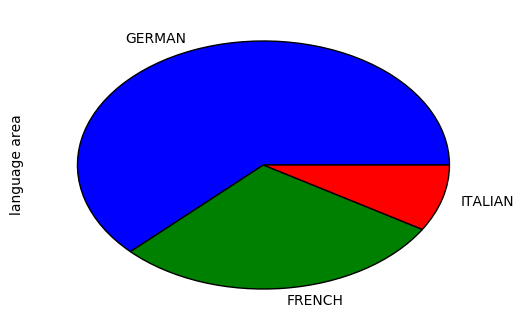

In [401]:
# Count the number of universities in different speaking area.
univ_number_lang = university_df_bi_map['language area'].value_counts().plot.pie()


This shows the number of institutions/universities in German-speaking area which received funding in past 40 year is much more than other language speaking area.  

Then we are going to explore the funding amount difference of those speaking area.

In [403]:
total_amount_dif = university_df_bi_map[['amount','language area']].groupby('language area').aggregate(np.sum)
total_amount_dif 

,amount
language area,
FRENCH,5.215734e+09
GERMAN,7.005366e+09
ITALIAN,1.151030e+08


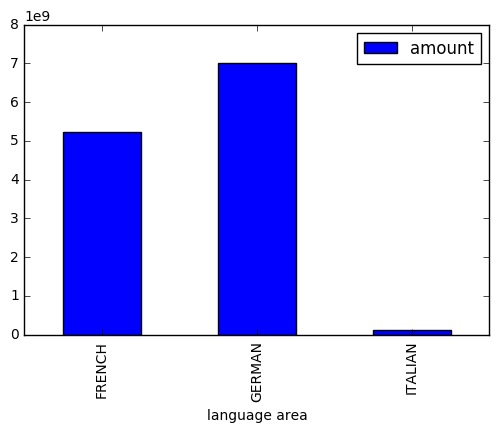

In [402]:
total_amount_dif.plot.bar()

Still, we see that considering total funding amount, German speaking area has its superiority.  

Now we consider average funding amount per university.

In [406]:
mean_amount_dif = university_df_bi_map[['amount','language area']].groupby('language area').mean()
mean_amount_dif

,amount
language area,
FRENCH,2.607867e+08
GERMAN,1.629155e+08
ITALIAN,1.918383e+07


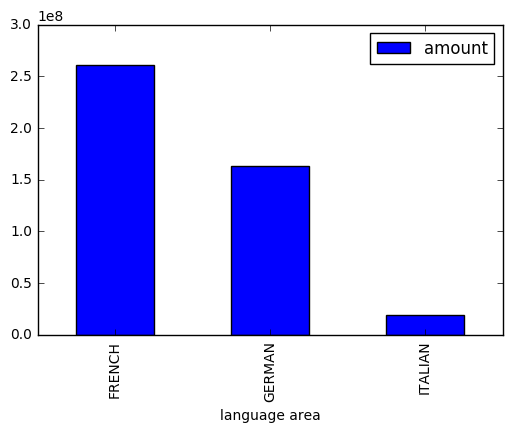

In [407]:
mean_amount_dif.plot.bar()

We see that when it comes to average funding per university, French speaking get the first place.

**Conclusion**:
1. Considering total funding amount and number of universities which receive funding, the rank will be German speaking area > French> Italian.
2. Considering average funding amount per university, the rank will be French speaking area > German> Italian.